# The Cat Boost Notebook notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)
- Removes repeated values in y-set B and C

It takes over from feature_engineering_1
Adds some ratio features from feature_engineering_3

**Takes over from cleaning_2.ipynb**


Uses catboost. Hyperparameter tuning using optuna.


# 154 notebook!

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [3]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True
            
    threshold = 6

    return sorted([t for t in intervals if t[1] - t[0] >= threshold], key=lambda t: t[1] - t[0], reverse=True)

In [4]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


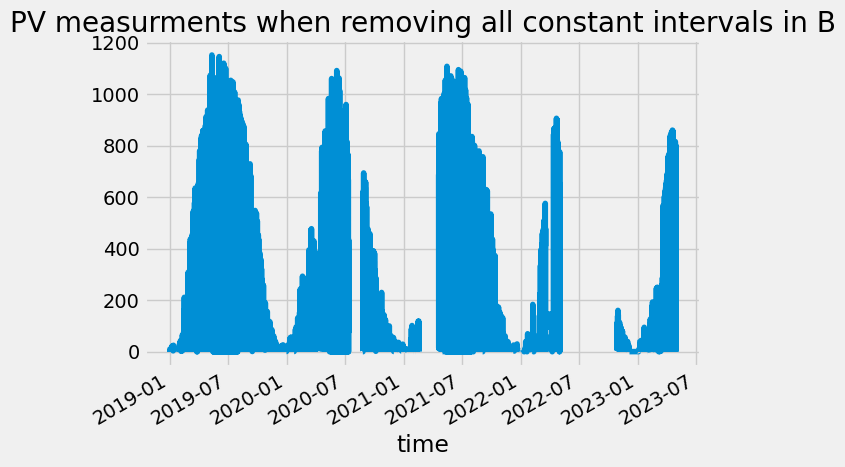

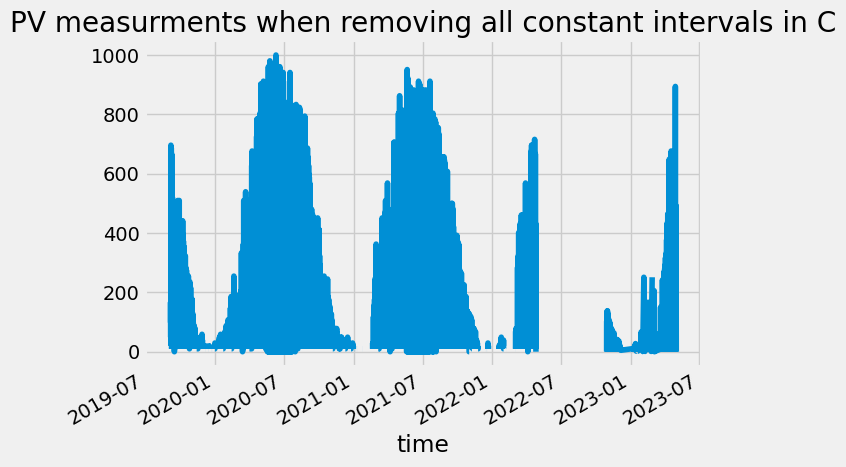

In [5]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [6]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [8]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [9]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [10]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with mean.

In [11]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').median()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').median()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').median()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').median()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').median()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').median()


In [12]:
X_train_observed_a.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [13]:
f = 'air_density_2m:kgm3'

In [14]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)
    #median_value = df[feature].median()

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

In [15]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa'
            
]

# 'air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa', 'wind_speed_10m:ms',
# 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms'

#0.04391554145075651

for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [16]:
#median = X_train_observed_a['air_density_2m:kgm3'].median()

#outliers_indices = (X_train_observed_a['air_density_2m:kgm3'] < 1.15) | (X_train_observed_a['air_density_2m:kgm3'] > 1.41)
#X_train_observed_a.loc[outliers_indices, 'air_density_2m:kgm3'] = np.nan
#X_train_observed_a['air_density_2m:kgm3'].interpolate(method='spline', order=3, inplace=True)
#X_train_observed_a[f].plot(style='o')

In [17]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [18]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

One hot encoding on location

In [19]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [20]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,0.0,278.349991,85.350002,16512.299805,2.90,1.10,2.65,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0,NaT
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,0.1,278.050003,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0,NaT


In [21]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,3,0,0.934996,0.354658,-0.0,0.0,0.0,0.0,0.223333,2.550000e+08
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,3,0,0.934934,0.354821,-0.0,0.0,0.0,0.0,0.227706,2.650000e+08
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,3,0,0.761584,0.648067,-0.0,0.0,0.0,0.0,0.231776,3.350000e+08
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,3,0,0.761815,0.647794,-0.0,0.0,0.0,0.0,0.229537,3.200000e+08
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,3,0,0.531894,0.846811,-0.0,0.0,0.0,0.0,0.229352,3.450000e+08


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [22]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth', 'interaction_clear_sky_rad_sun_elevation',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [23]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [24]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3       72
air_density_2m:kgm3          1824
clear_sky_energy_1h:J          72
clear_sky_rad:W                72
dew_or_rime:idx                72
                            ...  
location_A                      0
location_B                      0
location_C                      0
estimated                       0
pv_measurement              40896
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 42788 ROWS BEING DROPPED. THE DATASET HAS 56298 ROWS IN TOTAL.


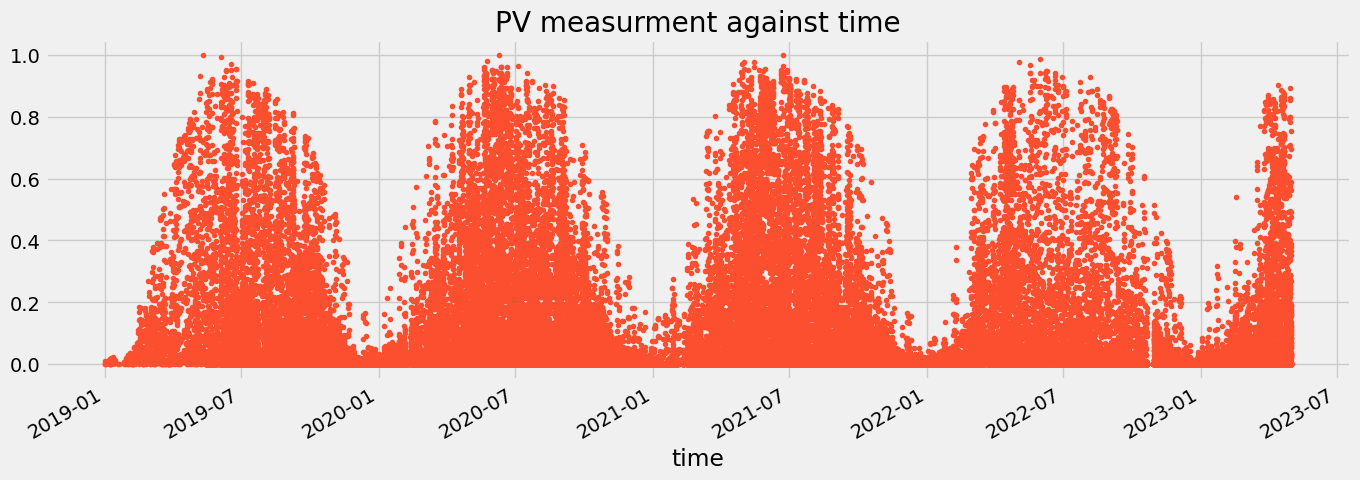

In [25]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').median()

    x_test = create_features(x_test)

    if location == 'A':
        x_test['location_A'] =  1
        x_test['location_B'] = 0
        x_test['location_C'] = 0
    elif location == 'B':
        x_test['location_A'] =  0
        x_test['location_B'] = 1
        x_test['location_C'] = 0
    elif location == 'C':
        x_test['location_A'] =  0
        x_test['location_B'] = 0
        x_test['location_C'] = 1

    return x_test

In [27]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [28]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [29]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [30]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [31]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [32]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [33]:
X_train = df[FEATURES]
y_train = df[TARGET]

In [34]:
import optuna
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 500, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 300),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 100.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        'loss_function':'MAE'
    }

    if param["grow_policy"] == "Lossguide":
        param["max_leaves"] = trial.suggest_int("max_leaves", 31, 1024, log=True)



    cv_dataset = Pool(data=X_train, label=y_train)


    scores = cv(cv_dataset,
                    params=param,
                    fold_count=5,
                    plot=False,
                    type="TimeSeries",
                    verbose=False)
    

    # Extract the best score
    best_score = np.min(scores['test-MAE-mean'])
    
    return best_score

/Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
trials = 80

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=trials, n_jobs=-1, show_progress_bar=True)  

[I 2023-10-23 14:13:56,791] A new study created in memory with name: no-name-0a8731a5-0b10-4817-88f4-ce781175339c
  0%|          | 0/80 [00:00<?, ?it/s]

Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]
Training on fold [0/5]

bestTest = 0.04910873306
bestIteration = 687

Training on fold [1/5]

bestTest = 0.06581853786
bestIteration = 703

Training on fold [1/5]

bestTest = 0.1252390772
bestIteration = 606

Training on fold [1/5]

bestTest = 0.03681664148
bestIteration = 690

Training on fold [2/5]

bestTest = 0.04128748192
bestIteration = 703

Training on fold [2/5]

bestTest = 0.08187756489
bestIteration = 606

Training on fold [2/5]

bestTest = 0.06352667274
bestIteration = 690

Training on fold [3/5]

bestTest = 0.09147273759
bestIteration = 703

Training on fold [3/5]

bestTest = 0.1189875391
bestIteration = 1453

Training on fold [1/5]

bestTest = 0.1231877795
bestIteration = 1135

Training on fold [1/5]

bestTest = 0.1823759822
bestIteration = 606

Training on fold [3/5]

bestTest = 0.03788230082
bestIteration = 689

T

Best trial: 7. Best value: 0.0455001:   1%|▏         | 1/80 [01:27<1:55:41, 87.86s/it]


bestTest = 0.04016373817
bestIteration = 690

[I 2023-10-23 14:15:24,673] Trial 7 finished with value: 0.04550005980774231 and parameters: {'iterations': 691, 'learning_rate': 0.015172186211729766, 'depth': 2, 'colsample_bylevel': 0.7413301631259933, 'min_data_in_leaf': 193, 'l2_leaf_reg': 0.002376833930832373, 'border_count': 25, 'random_strength': 4.55569518983009, 'bagging_temperature': 86.35691949081429, 'grow_policy': 'Lossguide', 'max_leaves': 216}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.1124430985
bestIteration = 656

Training on fold [1/5]


Best trial: 7. Best value: 0.0455001:   2%|▎         | 2/80 [01:38<55:05, 42.38s/it]  


bestTest = 0.0434234156
bestIteration = 703

[I 2023-10-23 14:15:35,217] Trial 4 finished with value: 0.057132549310702475 and parameters: {'iterations': 704, 'learning_rate': 0.0033108553894395927, 'depth': 11, 'colsample_bylevel': 0.05357517713004664, 'min_data_in_leaf': 73, 'l2_leaf_reg': 1.7085173886526063e-08, 'border_count': 251, 'random_strength': 8.239346936127328, 'bagging_temperature': 90.85789496857689, 'grow_policy': 'SymmetricTree'}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.07016588861
bestIteration = 656

Training on fold [2/5]


Best trial: 7. Best value: 0.0455001:   4%|▍         | 3/80 [01:52<37:34, 29.27s/it]


bestTest = 0.07714764262
bestIteration = 606

[I 2023-10-23 14:15:48,894] Trial 3 finished with value: 0.10984728763621268 and parameters: {'iterations': 607, 'learning_rate': 0.00047141829720894835, 'depth': 7, 'colsample_bylevel': 0.33257541976352145, 'min_data_in_leaf': 221, 'l2_leaf_reg': 0.007004727215584999, 'border_count': 16, 'random_strength': 4.0943113662838275, 'bagging_temperature': 97.73078526583551, 'grow_policy': 'SymmetricTree'}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.1620004066
bestIteration = 650

Training on fold [3/5]

bestTest = 0.07744406166
bestIteration = 1453

Training on fold [2/5]

bestTest = 0.07346331659
bestIteration = 656

Training on fold [4/5]

bestTest = 0.1382510022
bestIteration = 1196

Training on fold [1/5]

bestTest = 0.0797665719
bestIteration = 1135

Training on fold [2/5]


Best trial: 7. Best value: 0.0455001:   5%|▌         | 4/80 [02:20<36:33, 28.86s/it]


bestTest = 0.06975461908
bestIteration = 656

[I 2023-10-23 14:16:17,126] Trial 8 finished with value: 0.09756676983820564 and parameters: {'iterations': 657, 'learning_rate': 0.004089961048679482, 'depth': 10, 'colsample_bylevel': 0.012232066807773896, 'min_data_in_leaf': 145, 'l2_leaf_reg': 6.611504156328378e-07, 'border_count': 49, 'random_strength': 0.1915756631998633, 'bagging_temperature': 25.131617654687545, 'grow_policy': 'Lossguide', 'max_leaves': 449}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.0756897205
bestIteration = 1220

Training on fold [1/5]

bestTest = 0.1206691195
bestIteration = 752

Training on fold [1/5]

bestTest = 0.09281709115
bestIteration = 1196

Training on fold [2/5]

bestTest = 0.173228919
bestIteration = 1453

Training on fold [3/5]

bestTest = 0.2003967466
bestIteration = 1196

Training on fold [3/5]

bestTest = 0.1806841687
bestIteration = 1135

Training on fold [3/5]

bestTest = 0.1259214628
bestIteration = 

Best trial: 7. Best value: 0.0455001:   6%|▋         | 5/80 [05:01<1:35:55, 76.75s/it]


bestTest = 0.085744331
bestIteration = 1196

[I 2023-10-23 14:18:58,773] Trial 9 finished with value: 0.12196943113190033 and parameters: {'iterations': 1197, 'learning_rate': 0.0001028077290772165, 'depth': 12, 'colsample_bylevel': 0.19122897196667993, 'min_data_in_leaf': 70, 'l2_leaf_reg': 5.639510309871942, 'border_count': 30, 'random_strength': 2.8491846466789488, 'bagging_temperature': 52.7973655187167, 'grow_policy': 'SymmetricTree'}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.080956513
bestIteration = 1135

Training on fold [4/5]

bestTest = 0.133821563
bestIteration = 1130

Training on fold [1/5]

bestTest = 0.08726159614
bestIteration = 1130

Training on fold [2/5]

bestTest = 0.195515424
bestIteration = 1130

Training on fold [3/5]


Best trial: 7. Best value: 0.0455001:   8%|▊         | 6/80 [05:51<1:23:15, 67.51s/it]


bestTest = 0.0734464303
bestIteration = 1453

[I 2023-10-23 14:19:48,360] Trial 0 finished with value: 0.10432788982743009 and parameters: {'iterations': 1454, 'learning_rate': 0.00024289075800403806, 'depth': 9, 'colsample_bylevel': 0.8639951326764587, 'min_data_in_leaf': 166, 'l2_leaf_reg': 9.368047382794797e-07, 'border_count': 60, 'random_strength': 9.931831158081877, 'bagging_temperature': 82.63595257168899, 'grow_policy': 'SymmetricTree'}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.0879662586
bestIteration = 1130

Training on fold [4/5]


Best trial: 7. Best value: 0.0455001:   9%|▉         | 7/80 [06:19<1:06:19, 54.52s/it]


bestTest = 0.08118602093
bestIteration = 1130

[I 2023-10-23 14:20:16,119] Trial 12 finished with value: 0.11715017254050748 and parameters: {'iterations': 1131, 'learning_rate': 0.00022111053891608136, 'depth': 1, 'colsample_bylevel': 0.5116895591559717, 'min_data_in_leaf': 93, 'l2_leaf_reg': 0.012681976949329371, 'border_count': 129, 'random_strength': 2.5804568964729366, 'bagging_temperature': 95.51522243999855, 'grow_policy': 'Lossguide', 'max_leaves': 200}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.1088191368
bestIteration = 947

Training on fold [1/5]

bestTest = 0.07882098172
bestIteration = 752

Training on fold [2/5]


Best trial: 7. Best value: 0.0455001:  10%|█         | 8/80 [06:47<55:17, 46.07s/it]  


bestTest = 0.07567090585
bestIteration = 1135

[I 2023-10-23 14:20:44,109] Trial 2 finished with value: 0.10805318777829025 and parameters: {'iterations': 1136, 'learning_rate': 0.0003586585944602226, 'depth': 14, 'colsample_bylevel': 0.06564357870825557, 'min_data_in_leaf': 9, 'l2_leaf_reg': 5.006211393873379e-08, 'border_count': 73, 'random_strength': 5.012464004229241, 'bagging_temperature': 62.466004809411935, 'grow_policy': 'Lossguide', 'max_leaves': 35}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.06935984967
bestIteration = 947

Training on fold [2/5]

bestTest = 0.04907181226
bestIteration = 547

Training on fold [1/5]

bestTest = 0.04746610458
bestIteration = 1220

Training on fold [2/5]

bestTest = 0.03709639634
bestIteration = 547

Training on fold [2/5]

bestTest = 0.06274767165
bestIteration = 547

Training on fold [3/5]

bestTest = 0.03815239945
bestIteration = 545

Training on fold [4/5]

bestTest = 0.08378062698
bestIteration =

Best trial: 7. Best value: 0.0455001:  11%|█▏        | 9/80 [07:36<55:48, 47.17s/it]


bestTest = 0.04061521293
bestIteration = 547

[I 2023-10-23 14:21:33,689] Trial 15 finished with value: 0.04553671369043853 and parameters: {'iterations': 548, 'learning_rate': 0.02870924747113749, 'depth': 2, 'colsample_bylevel': 0.2503555935876746, 'min_data_in_leaf': 169, 'l2_leaf_reg': 0.20284913739976884, 'border_count': 195, 'random_strength': 9.210432968238221, 'bagging_temperature': 13.737655119152759, 'grow_policy': 'Depthwise'}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.04486756389
bestIteration = 845

Training on fold [2/5]

bestTest = 0.04961102472
bestIteration = 665

Training on fold [1/5]

bestTest = 0.07156803485
bestIteration = 947

Training on fold [4/5]

bestTest = 0.03516299971
bestIteration = 909

Training on fold [2/5]


Best trial: 7. Best value: 0.0455001:  12%|█▎        | 10/80 [09:03<1:09:04, 59.20s/it]


bestTest = 0.06721805272
bestIteration = 947

[I 2023-10-23 14:22:59,832] Trial 13 finished with value: 0.09509167194955373 and parameters: {'iterations': 948, 'learning_rate': 0.0005258027494682951, 'depth': 8, 'colsample_bylevel': 0.5141146755986641, 'min_data_in_leaf': 185, 'l2_leaf_reg': 5.616303740618998e-08, 'border_count': 4, 'random_strength': 4.16245757466192, 'bagging_temperature': 6.629338191727574, 'grow_policy': 'SymmetricTree'}. Best is trial 7 with value: 0.04550005980774231.
Training on fold [0/5]

bestTest = 0.06224970044
bestIteration = 1480

Training on fold [1/5]

bestTest = 0.05828563903
bestIteration = 910

Training on fold [3/5]

bestTest = 0.04972886557
bestIteration = 123

Training on fold [1/5]

bestTest = 0.03322162709
bestIteration = 907

Training on fold [4/5]

bestTest = 0.03708543423
bestIteration = 204

Training on fold [2/5]


Best trial: 16. Best value: 0.042005:  14%|█▍        | 11/80 [10:54<1:26:38, 75.34s/it]


bestTest = 0.03344091673
bestIteration = 910

[I 2023-10-23 14:24:51,752] Trial 16 finished with value: 0.04200498563502304 and parameters: {'iterations': 911, 'learning_rate': 0.009049444201668574, 'depth': 10, 'colsample_bylevel': 0.803535140144627, 'min_data_in_leaf': 244, 'l2_leaf_reg': 5.124421313092502e-07, 'border_count': 171, 'random_strength': 4.185104936181945, 'bagging_temperature': 85.07890544398904, 'grow_policy': 'SymmetricTree'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.05836930916
bestIteration = 403

Training on fold [3/5]

bestTest = 0.04765350391
bestIteration = 537

Training on fold [1/5]

bestTest = 0.1747612961
bestIteration = 752

Training on fold [3/5]

bestTest = 0.1837039198
bestIteration = 862

Training on fold [3/5]

bestTest = 0.03586860102
bestIteration = 783

Training on fold [2/5]

bestTest = 0.03359603507
bestIteration = 867

Training on fold [4/5]

bestTest = 0.1021229279
bestIteration = 845

Training on f

Best trial: 16. Best value: 0.042005:  15%|█▌        | 12/80 [13:05<1:44:24, 92.13s/it]


bestTest = 0.0339552022
bestIteration = 864

[I 2023-10-23 14:27:02,299] Trial 17 finished with value: 0.043414583324694514 and parameters: {'iterations': 868, 'learning_rate': 0.09824211524106946, 'depth': 5, 'colsample_bylevel': 0.9962311233006087, 'min_data_in_leaf': 296, 'l2_leaf_reg': 7.599551074848321e-05, 'border_count': 113, 'random_strength': 6.9528067297742515, 'bagging_temperature': 75.42802385658494, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.0584505477
bestIteration = 854

Training on fold [3/5]

bestTest = 0.04935041095
bestIteration = 88

Training on fold [1/5]

bestTest = 0.05154564322
bestIteration = 884

Training on fold [1/5]

bestTest = 0.1066401629
bestIteration = 1220

Training on fold [3/5]

bestTest = 0.03427899958
bestIteration = 854

Training on fold [4/5]

bestTest = 0.03676277285
bestIteration = 366

Training on fold [2/5]

bestTest = 0.03997522345
bestIteration = 1480

Training on fol

Best trial: 16. Best value: 0.042005:  16%|█▋        | 13/80 [15:10<1:54:06, 102.19s/it]


bestTest = 0.03572184529
bestIteration = 852

[I 2023-10-23 14:29:07,631] Trial 18 finished with value: 0.042512122711116006 and parameters: {'iterations': 855, 'learning_rate': 0.02133524308529833, 'depth': 5, 'colsample_bylevel': 0.8300280451269204, 'min_data_in_leaf': 292, 'l2_leaf_reg': 7.9808097198393e-05, 'border_count': 134, 'random_strength': 6.125726471141425, 'bagging_temperature': 74.94069858503313, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.05815352969
bestIteration = 563

Training on fold [3/5]

bestTest = 0.04844952392
bestIteration = 870

Training on fold [1/5]

bestTest = 0.03351043315
bestIteration = 883

Training on fold [4/5]

bestTest = 0.03614972429
bestIteration = 871

Training on fold [2/5]


Best trial: 16. Best value: 0.042005:  18%|█▊        | 14/80 [17:01<1:55:16, 104.79s/it]


bestTest = 0.03346027065
bestIteration = 881

[I 2023-10-23 14:30:58,434] Trial 19 finished with value: 0.042947611924786265 and parameters: {'iterations': 886, 'learning_rate': 0.09125632474786778, 'depth': 5, 'colsample_bylevel': 0.9395292992637455, 'min_data_in_leaf': 296, 'l2_leaf_reg': 1.4002860374597836e-05, 'border_count': 136, 'random_strength': 6.829573905759279, 'bagging_temperature': 70.75434740611402, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.07995741895
bestIteration = 752

Training on fold [4/5]

bestTest = 0.0839505643
bestIteration = 862

Training on fold [4/5]

bestTest = 0.06060739877
bestIteration = 871

Training on fold [3/5]

bestTest = 0.04769867779
bestIteration = 845

Training on fold [4/5]

bestTest = 0.03586496279
bestIteration = 871

Training on fold [4/5]

bestTest = 0.04902375162
bestIteration = 656

Training on fold [1/5]


Best trial: 16. Best value: 0.042005:  19%|█▉        | 15/80 [19:37<2:10:20, 120.31s/it]


bestTest = 0.03776266549
bestIteration = 871

[I 2023-10-23 14:33:34,710] Trial 20 finished with value: 0.0437671134616053 and parameters: {'iterations': 872, 'learning_rate': 0.008157975334733928, 'depth': 5, 'colsample_bylevel': 0.6625532735556592, 'min_data_in_leaf': 300, 'l2_leaf_reg': 3.0174621067147204e-05, 'border_count': 169, 'random_strength': 6.584705911246904, 'bagging_temperature': 70.60157974883151, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.08471792391
bestIteration = 1480

Training on fold [3/5]

bestTest = 0.04974287193
bestIteration = 1220

Training on fold [4/5]

bestTest = 0.0681538022
bestIteration = 776

Training on fold [1/5]

bestTest = 0.03537056676
bestIteration = 799

Training on fold [2/5]


Best trial: 16. Best value: 0.042005:  20%|██        | 16/80 [22:15<2:20:21, 131.59s/it]


bestTest = 0.07493508913
bestIteration = 752

[I 2023-10-23 14:36:12,481] Trial 5 finished with value: 0.10582878109088367 and parameters: {'iterations': 753, 'learning_rate': 0.00040443906242264565, 'depth': 12, 'colsample_bylevel': 0.6820850359992848, 'min_data_in_leaf': 72, 'l2_leaf_reg': 2.3096330237668607e-08, 'border_count': 202, 'random_strength': 0.15273095685457477, 'bagging_temperature': 22.076850519379366, 'grow_policy': 'Lossguide', 'max_leaves': 246}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]


Best trial: 16. Best value: 0.042005:  21%|██▏       | 17/80 [22:35<1:42:45, 97.87s/it] 


bestTest = 0.078090095
bestIteration = 862

[I 2023-10-23 14:36:31,933] Trial 10 finished with value: 0.11108933377099173 and parameters: {'iterations': 863, 'learning_rate': 0.0002863359078589577, 'depth': 12, 'colsample_bylevel': 0.5839612475792053, 'min_data_in_leaf': 121, 'l2_leaf_reg': 1.8354753932762853e-05, 'border_count': 183, 'random_strength': 7.526537351867253, 'bagging_temperature': 13.018975304444336, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]


Best trial: 16. Best value: 0.042005:  22%|██▎       | 18/80 [22:56<1:17:29, 74.99s/it]


bestTest = 0.0463534403
bestIteration = 845

[I 2023-10-23 14:36:53,653] Trial 11 finished with value: 0.06265818107339798 and parameters: {'iterations': 846, 'learning_rate': 0.0015346036124049087, 'depth': 12, 'colsample_bylevel': 0.23716520775350014, 'min_data_in_leaf': 68, 'l2_leaf_reg': 9.500189901925903e-06, 'border_count': 238, 'random_strength': 4.302708690893421, 'bagging_temperature': 46.88079169936965, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.04331284065
bestIteration = 776

Training on fold [2/5]

bestTest = 0.06376193677
bestIteration = 1025

Training on fold [1/5]

bestTest = 0.06177672263
bestIteration = 1045

Training on fold [1/5]

bestTest = 0.05462388126
bestIteration = 254

Training on fold [1/5]

bestTest = 0.05982959381
bestIteration = 808

Training on fold [3/5]

bestTest = 0.03509007201
bestIteration = 562

Training on fold [2/5]

bestTest = 0.04185987992
bestIteration = 1480

Training o

Best trial: 16. Best value: 0.042005:  24%|██▍       | 19/80 [50:15<9:13:47, 544.72s/it]


bestTest = 0.04795242367
bestIteration = 1220

[I 2023-10-23 15:04:12,620] Trial 1 finished with value: 0.06549825672593526 and parameters: {'iterations': 1221, 'learning_rate': 0.0009198761231480223, 'depth': 15, 'colsample_bylevel': 0.5530514911660753, 'min_data_in_leaf': 272, 'l2_leaf_reg': 0.0024384124492412215, 'border_count': 82, 'random_strength': 2.698807675048152, 'bagging_temperature': 93.45558032745986, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.06072927898
bestIteration = 424

Training on fold [3/5]

bestTest = 0.04863423835
bestIteration = 891

Training on fold [1/5]

bestTest = 0.03484068337
bestIteration = 920

Training on fold [2/5]

bestTest = 0.03571343146
bestIteration = 1023

Training on fold [2/5]

bestTest = 0.05956514784
bestIteration = 1040

Training on fold [3/5]

bestTest = 0.03259562034
bestIteration = 810

Training on fold [4/5]

bestTest = 0.03458065483
bestIteration = 1041

Training 

Best trial: 16. Best value: 0.042005:  25%|██▌       | 20/80 [1:02:25<10:00:11, 600.19s/it]


bestTest = 0.03610301129
bestIteration = 1041

[I 2023-10-23 15:16:22,112] Trial 26 finished with value: 0.04295365230435515 and parameters: {'iterations': 1042, 'learning_rate': 0.008667576740251419, 'depth': 7, 'colsample_bylevel': 0.809545769831665, 'min_data_in_leaf': 246, 'l2_leaf_reg': 0.00035634270015192575, 'border_count': 162, 'random_strength': 5.725411689391646, 'bagging_temperature': 80.34411767564517, 'grow_policy': 'SymmetricTree'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.0453578794
bestIteration = 776

Training on fold [4/5]

bestTest = 0.08753041309
bestIteration = 1025

Training on fold [3/5]

bestTest = 0.08631474595
bestIteration = 1045

Training on fold [3/5]


Best trial: 16. Best value: 0.042005:  26%|██▋       | 21/80 [1:22:39<12:51:21, 784.44s/it]


bestTest = 0.03292546714
bestIteration = 550

[I 2023-10-23 15:36:36,091] Trial 25 finished with value: 0.043398100303361026 and parameters: {'iterations': 1046, 'learning_rate': 0.020855379286400775, 'depth': 16, 'colsample_bylevel': 0.8098368363260466, 'min_data_in_leaf': 250, 'l2_leaf_reg': 1.3875226096486288e-06, 'border_count': 93, 'random_strength': 5.7480975791808016, 'bagging_temperature': 81.74716774291613, 'grow_policy': 'SymmetricTree'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]


Best trial: 16. Best value: 0.042005:  28%|██▊       | 22/80 [1:23:19<9:02:17, 560.99s/it] 


bestTest = 0.04161460572
bestIteration = 1480

[I 2023-10-23 15:37:16,016] Trial 14 finished with value: 0.05408346668559223 and parameters: {'iterations': 1481, 'learning_rate': 0.001208704981275927, 'depth': 12, 'colsample_bylevel': 0.3446505109543851, 'min_data_in_leaf': 165, 'l2_leaf_reg': 3.3413837060338808e-06, 'border_count': 70, 'random_strength': 5.836451007623169, 'bagging_temperature': 20.1555597464538, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.05303313252
bestIteration = 195

Training on fold [1/5]

bestTest = 0.04976655249
bestIteration = 172

Training on fold [1/5]

bestTest = 0.04852267031
bestIteration = 177

Training on fold [1/5]

bestTest = 0.03692167213
bestIteration = 195

Training on fold [2/5]

bestTest = 0.03647245828
bestIteration = 678

Training on fold [2/5]

bestTest = 0.05792610391
bestIteration = 626

Training on fold [3/5]

bestTest = 0.05794546242
bestIteration = 681

Training on 

Best trial: 16. Best value: 0.042005:  29%|██▉       | 23/80 [1:35:47<9:46:23, 617.26s/it]


bestTest = 0.03321736802
bestIteration = 810

[I 2023-10-23 15:49:44,509] Trial 21 finished with value: 0.04202344266494391 and parameters: {'iterations': 811, 'learning_rate': 0.010605953633889286, 'depth': 16, 'colsample_bylevel': 0.7282902041722165, 'min_data_in_leaf': 244, 'l2_leaf_reg': 1.4678791031607108e-05, 'border_count': 167, 'random_strength': 6.224038771983205, 'bagging_temperature': 68.0494911899051, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.03312611677
bestIteration = 957

Training on fold [4/5]

bestTest = 0.03390339194
bestIteration = 943

Training on fold [4/5]

bestTest = 0.0348089264
bestIteration = 389

Training on fold [2/5]


Best trial: 16. Best value: 0.042005:  30%|███       | 24/80 [1:40:34<8:03:32, 518.07s/it]


bestTest = 0.0342581522
bestIteration = 935

[I 2023-10-23 15:54:31,225] Trial 29 finished with value: 0.04258093381825574 and parameters: {'iterations': 947, 'learning_rate': 0.0683305645668113, 'depth': 5, 'colsample_bylevel': 0.9859803736168496, 'min_data_in_leaf': 267, 'l2_leaf_reg': 0.00018519792003820633, 'border_count': 144, 'random_strength': 7.614174822598123, 'bagging_temperature': 67.85514886097464, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]


Best trial: 16. Best value: 0.042005:  31%|███▏      | 25/80 [1:40:42<5:34:38, 365.07s/it]


bestTest = 0.03311995659
bestIteration = 948

[I 2023-10-23 15:54:39,349] Trial 28 finished with value: 0.043240416592279285 and parameters: {'iterations': 959, 'learning_rate': 0.08191429583797188, 'depth': 5, 'colsample_bylevel': 0.9525495437421636, 'min_data_in_leaf': 267, 'l2_leaf_reg': 3.5096763242502704e-06, 'border_count': 130, 'random_strength': 6.3409981795507715, 'bagging_temperature': 70.16764660519256, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.04836866955
bestIteration = 203

Training on fold [1/5]


Best trial: 16. Best value: 0.042005:  32%|███▎      | 26/80 [1:43:12<4:30:33, 300.63s/it]


bestTest = 0.04474960119
bestIteration = 776

[I 2023-10-23 15:57:09,627] Trial 22 finished with value: 0.059681407469991135 and parameters: {'iterations': 777, 'learning_rate': 0.0018178034944060088, 'depth': 15, 'colsample_bylevel': 0.8000242602725098, 'min_data_in_leaf': 245, 'l2_leaf_reg': 2.6910823123478635e-06, 'border_count': 203, 'random_strength': 6.041352674880079, 'bagging_temperature': 61.0238471526909, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.05246132745
bestIteration = 766

Training on fold [1/5]

bestTest = 0.04955492031
bestIteration = 200

Training on fold [1/5]

bestTest = 0.04894665911
bestIteration = 232

Training on fold [1/5]

bestTest = 0.04252720415
bestIteration = 1025

Training on fold [4/5]

bestTest = 0.03494302021
bestIteration = 767

Training on fold [2/5]

bestTest = 0.03565302699
bestIteration = 405

Training on fold [2/5]

bestTest = 0.06178236765
bestIteration = 769

Training o

Best trial: 16. Best value: 0.042005:  34%|███▍      | 27/80 [2:20:33<12:59:36, 882.58s/it]


bestTest = 0.03411551576
bestIteration = 769

[I 2023-10-23 16:34:29,957] Trial 33 finished with value: 0.04338344147892459 and parameters: {'iterations': 770, 'learning_rate': 0.006135011018017481, 'depth': 14, 'colsample_bylevel': 0.8614258182971694, 'min_data_in_leaf': 220, 'l2_leaf_reg': 1.9784294624295067e-07, 'border_count': 221, 'random_strength': 5.123990731979792, 'bagging_temperature': 80.05992782856278, 'grow_policy': 'SymmetricTree'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.04991367813
bestIteration = 536

Training on fold [1/5]

bestTest = 0.03693213047
bestIteration = 535

Training on fold [2/5]

bestTest = 0.06278678424
bestIteration = 536

Training on fold [3/5]

bestTest = 0.0372639783
bestIteration = 536

Training on fold [4/5]

bestTest = 0.05876255902
bestIteration = 636

Training on fold [3/5]


Best trial: 16. Best value: 0.042005:  35%|███▌      | 28/80 [2:26:27<10:27:27, 723.99s/it]


bestTest = 0.03947826473
bestIteration = 536

[I 2023-10-23 16:40:23,951] Trial 34 finished with value: 0.045275288918748165 and parameters: {'iterations': 537, 'learning_rate': 0.013902861230166751, 'depth': 3, 'colsample_bylevel': 0.6491800369530483, 'min_data_in_leaf': 232, 'l2_leaf_reg': 1.2131291210598952e-07, 'border_count': 154, 'random_strength': 8.121355696888472, 'bagging_temperature': 88.29616046971051, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.03298010632
bestIteration = 298

Training on fold [4/5]

bestTest = 0.06072652796
bestIteration = 767

Training on fold [3/5]

bestTest = 0.05866417041
bestIteration = 675

Training on fold [3/5]

bestTest = 0.04821216446
bestIteration = 247

Training on fold [1/5]

bestTest = 0.03605947019
bestIteration = 419

Training on fold [2/5]

bestTest = 0.03236402264
bestIteration = 466

Training on fold [4/5]


Best trial: 16. Best value: 0.042005:  36%|███▋      | 29/80 [2:40:52<10:51:21, 766.31s/it]


bestTest = 0.04234640237
bestIteration = 1025

[I 2023-10-23 16:54:49,002] Trial 23 finished with value: 0.05540049036260597 and parameters: {'iterations': 1026, 'learning_rate': 0.0016172898558236067, 'depth': 15, 'colsample_bylevel': 0.8347194922726369, 'min_data_in_leaf': 249, 'l2_leaf_reg': 0.00035973992813820966, 'border_count': 94, 'random_strength': 6.414416111992768, 'bagging_temperature': 46.49875704836076, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.03245699133
bestIteration = 485

Training on fold [4/5]

bestTest = 0.05752645191
bestIteration = 745

Training on fold [3/5]

bestTest = 0.05026263612
bestIteration = 302

Training on fold [1/5]


Best trial: 16. Best value: 0.042005:  38%|███▊      | 30/80 [2:44:30<8:21:28, 601.76s/it] 


bestTest = 0.03278780757
bestIteration = 339

[I 2023-10-23 16:58:26,833] Trial 27 finished with value: 0.04369244265913407 and parameters: {'iterations': 1322, 'learning_rate': 0.032043676284261975, 'depth': 16, 'colsample_bylevel': 0.859446573458041, 'min_data_in_leaf': 235, 'l2_leaf_reg': 1.4692131913204702e-06, 'border_count': 110, 'random_strength': 5.751275206342339, 'bagging_temperature': 84.39411227925557, 'grow_policy': 'SymmetricTree'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.06231061463
bestIteration = 920

Training on fold [3/5]

bestTest = 0.03214569411
bestIteration = 517

Training on fold [4/5]

bestTest = 0.0350032111
bestIteration = 557

Training on fold [2/5]

bestTest = 0.04915835806
bestIteration = 1133

Training on fold [1/5]


Best trial: 16. Best value: 0.042005:  39%|███▉      | 31/80 [2:46:38<6:15:22, 459.64s/it]


bestTest = 0.04130846432
bestIteration = 1045

[I 2023-10-23 17:00:34,858] Trial 24 finished with value: 0.05410823165272366 and parameters: {'iterations': 1046, 'learning_rate': 0.0016888556070865353, 'depth': 16, 'colsample_bylevel': 0.794195793683244, 'min_data_in_leaf': 247, 'l2_leaf_reg': 0.00045676655430162657, 'border_count': 96, 'random_strength': 5.818730153127217, 'bagging_temperature': 80.84378091982066, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]

bestTest = 0.05905307861
bestIteration = 726

Training on fold [3/5]

bestTest = 0.0322233218
bestIteration = 1303

Training on fold [4/5]

bestTest = 0.03510468409
bestIteration = 1367

Training on fold [2/5]

bestTest = 0.04935131331
bestIteration = 222

Training on fold [1/5]

bestTest = 0.03231961847
bestIteration = 1061

Training on fold [4/5]

bestTest = 0.05868839772
bestIteration = 1378

Training on fold [3/5]


Best trial: 16. Best value: 0.042005:  40%|████      | 32/80 [2:49:53<5:04:21, 380.46s/it]


bestTest = 0.03261441562
bestIteration = 684

[I 2023-10-23 17:03:50,558] Trial 31 finished with value: 0.0422891818138044 and parameters: {'iterations': 778, 'learning_rate': 0.04035671780156896, 'depth': 14, 'colsample_bylevel': 0.8622224052484363, 'min_data_in_leaf': 219, 'l2_leaf_reg': 3.226247400876525e-07, 'border_count': 218, 'random_strength': 6.221861846139571, 'bagging_temperature': 62.34070369713971, 'grow_policy': 'Depthwise'}. Best is trial 16 with value: 0.04200498563502304.
Training on fold [0/5]


Best trial: 30. Best value: 0.0417825:  41%|████▏     | 33/80 [2:50:10<3:32:38, 271.45s/it]


bestTest = 0.03233072333
bestIteration = 572

[I 2023-10-23 17:04:07,654] Trial 30 finished with value: 0.04178252632010175 and parameters: {'iterations': 803, 'learning_rate': 0.03653541536150181, 'depth': 14, 'colsample_bylevel': 0.8607589050822506, 'min_data_in_leaf': 226, 'l2_leaf_reg': 0.00010587125223600398, 'border_count': 155, 'random_strength': 7.738231251317822, 'bagging_temperature': 64.66515963621686, 'grow_policy': 'Depthwise'}. Best is trial 30 with value: 0.04178252632010175.
Training on fold [0/5]

bestTest = 0.03628510283
bestIteration = 905

Training on fold [2/5]


Best trial: 30. Best value: 0.0417825:  42%|████▎     | 34/80 [2:50:49<2:34:32, 201.59s/it]


bestTest = 0.03190404844
bestIteration = 1177

[I 2023-10-23 17:04:46,236] Trial 36 finished with value: 0.042364271805783546 and parameters: {'iterations': 1315, 'learning_rate': 0.03279250105403617, 'depth': 9, 'colsample_bylevel': 0.7543335824486974, 'min_data_in_leaf': 204, 'l2_leaf_reg': 7.274304333111706e-07, 'border_count': 178, 'random_strength': 9.408661793962066, 'bagging_temperature': 99.38960763223947, 'grow_policy': 'SymmetricTree'}. Best is trial 30 with value: 0.04178252632010175.
Training on fold [0/5]

bestTest = 0.03365023684
bestIteration = 1378

Training on fold [4/5]


Best trial: 30. Best value: 0.0417825:  44%|████▍     | 35/80 [2:51:00<1:48:24, 144.54s/it]


bestTest = 0.03239796986
bestIteration = 1283

[I 2023-10-23 17:04:57,654] Trial 35 finished with value: 0.04195284036946208 and parameters: {'iterations': 1316, 'learning_rate': 0.034272934117267964, 'depth': 7, 'colsample_bylevel': 0.7420428219745736, 'min_data_in_leaf': 205, 'l2_leaf_reg': 3.0355148510992765e-07, 'border_count': 104, 'random_strength': 5.236619990745458, 'bagging_temperature': 77.05198282960602, 'grow_policy': 'Depthwise'}. Best is trial 30 with value: 0.04178252632010175.
Training on fold [0/5]

bestTest = 0.04933939176
bestIteration = 262

Training on fold [1/5]


Best trial: 32. Best value: 0.0416351:  45%|████▌     | 36/80 [2:51:33<1:21:25, 111.04s/it]


bestTest = 0.03197059623
bestIteration = 752

[I 2023-10-23 17:05:30,524] Trial 32 finished with value: 0.04163510621622438 and parameters: {'iterations': 776, 'learning_rate': 0.03088614256477664, 'depth': 14, 'colsample_bylevel': 0.868938483544806, 'min_data_in_leaf': 216, 'l2_leaf_reg': 2.634108935336827e-07, 'border_count': 221, 'random_strength': 5.3159866454754265, 'bagging_temperature': 99.81971901023758, 'grow_policy': 'Depthwise'}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.05016688694
bestIteration = 189

Training on fold [1/5]

bestTest = 0.0494454878
bestIteration = 184

Training on fold [1/5]


Best trial: 32. Best value: 0.0416351:  46%|████▋     | 37/80 [2:52:31<1:08:11, 95.15s/it] 


bestTest = 0.03419098085
bestIteration = 1375

[I 2023-10-23 17:06:28,608] Trial 37 finished with value: 0.042187786723145895 and parameters: {'iterations': 1379, 'learning_rate': 0.005120520470100347, 'depth': 9, 'colsample_bylevel': 0.7584581264165802, 'min_data_in_leaf': 204, 'l2_leaf_reg': 4.845735364614163e-07, 'border_count': 180, 'random_strength': 3.6153224912644673, 'bagging_temperature': 98.9049896319456, 'grow_policy': 'SymmetricTree'}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.03627756481
bestIteration = 370

Training on fold [2/5]

bestTest = 0.04953051988
bestIteration = 98

Training on fold [1/5]

bestTest = 0.05793094612
bestIteration = 381

Training on fold [3/5]

bestTest = 0.0492740211
bestIteration = 115

Training on fold [1/5]

bestTest = 0.0365293824
bestIteration = 633

Training on fold [2/5]

bestTest = 0.03574994153
bestIteration = 325

Training on fold [2/5]

bestTest = 0.05796471666
bestIteration = 504

Training o

Best trial: 32. Best value: 0.0416351:  48%|████▊     | 38/80 [2:59:35<2:15:31, 193.60s/it]


bestTest = 0.03219445334
bestIteration = 949

[I 2023-10-23 17:13:31,907] Trial 38 finished with value: 0.04203429750282681 and parameters: {'iterations': 953, 'learning_rate': 0.04704642342187495, 'depth': 9, 'colsample_bylevel': 0.9219243038589947, 'min_data_in_leaf': 272, 'l2_leaf_reg': 8.790926780814816e-05, 'border_count': 148, 'random_strength': 7.521126118223157, 'bagging_temperature': 98.8749617204317, 'grow_policy': 'Depthwise'}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.06038876836
bestIteration = 353

Training on fold [3/5]

bestTest = 0.059418959
bestIteration = 414

Training on fold [3/5]

bestTest = 0.03599106375
bestIteration = 958

Training on fold [2/5]


Best trial: 32. Best value: 0.0416351:  49%|████▉     | 39/80 [3:01:21<1:54:18, 167.29s/it]


bestTest = 0.03212331299
bestIteration = 750

[I 2023-10-23 17:15:17,813] Trial 39 finished with value: 0.042101123247572224 and parameters: {'iterations': 756, 'learning_rate': 0.03696536016290347, 'depth': 9, 'colsample_bylevel': 0.8798692491107761, 'min_data_in_leaf': 200, 'l2_leaf_reg': 1.914343623946301e-07, 'border_count': 176, 'random_strength': 7.1124347373444285, 'bagging_temperature': 74.60956709078346, 'grow_policy': 'Depthwise'}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.06220957003
bestIteration = 631

Training on fold [3/5]

bestTest = 0.03241290794
bestIteration = 370

Training on fold [4/5]

bestTest = 0.0504787816
bestIteration = 150

Training on fold [1/5]

bestTest = 0.04833677465
bestIteration = 454

Training on fold [1/5]

bestTest = 0.0321644403
bestIteration = 505

Training on fold [4/5]

bestTest = 0.03265787812
bestIteration = 629

Training on fold [4/5]


Best trial: 32. Best value: 0.0416351:  50%|█████     | 40/80 [3:06:09<2:15:49, 203.75s/it]


bestTest = 0.03248383877
bestIteration = 511

[I 2023-10-23 17:20:06,636] Trial 41 finished with value: 0.04310220806899208 and parameters: {'iterations': 637, 'learning_rate': 0.045564630285284596, 'depth': 14, 'colsample_bylevel': 0.9219419345766908, 'min_data_in_leaf': 276, 'l2_leaf_reg': 2.027730536575483e-07, 'border_count': 227, 'random_strength': 7.277051088243477, 'bagging_temperature': 61.483124071577514, 'grow_policy': 'Depthwise'}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.03537179917
bestIteration = 605

Training on fold [2/5]

bestTest = 0.03262302262
bestIteration = 608

Training on fold [4/5]

bestTest = 0.03593082107
bestIteration = 358

Training on fold [2/5]

bestTest = 0.06037071239
bestIteration = 326

Training on fold [3/5]

bestTest = 0.04834155761
bestIteration = 324

Training on fold [1/5]


Best trial: 32. Best value: 0.0416351:  51%|█████▏    | 41/80 [3:09:18<2:09:28, 199.20s/it]


bestTest = 0.03254686111
bestIteration = 1137

[I 2023-10-23 17:23:15,225] Trial 42 finished with value: 0.04233446807858935 and parameters: {'iterations': 1313, 'learning_rate': 0.05346135046304157, 'depth': 10, 'colsample_bylevel': 0.7357339038408741, 'min_data_in_leaf': 199, 'l2_leaf_reg': 1.591766700038725e-07, 'border_count': 152, 'random_strength': 5.1569814492745945, 'bagging_temperature': 92.90925278849592, 'grow_policy': 'Depthwise'}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.05894492295
bestIteration = 635

Training on fold [3/5]


Best trial: 32. Best value: 0.0416351:  52%|█████▎    | 42/80 [3:10:22<1:40:31, 158.72s/it]


bestTest = 0.03204532153
bestIteration = 422

[I 2023-10-23 17:24:19,483] Trial 40 finished with value: 0.042296736848384586 and parameters: {'iterations': 797, 'learning_rate': 0.04450811741452978, 'depth': 14, 'colsample_bylevel': 0.9171752762543244, 'min_data_in_leaf': 208, 'l2_leaf_reg': 3.140465370410501e-07, 'border_count': 178, 'random_strength': 7.211593276911559, 'bagging_temperature': 59.623618048004516, 'grow_policy': 'Depthwise'}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]


Best trial: 32. Best value: 0.0416351:  54%|█████▍    | 43/80 [3:11:24<1:19:56, 129.64s/it]


bestTest = 0.03250413663
bestIteration = 877

[I 2023-10-23 17:25:21,288] Trial 43 finished with value: 0.04297434648681936 and parameters: {'iterations': 1403, 'learning_rate': 0.05181757312796678, 'depth': 10, 'colsample_bylevel': 0.914888286370163, 'min_data_in_leaf': 206, 'l2_leaf_reg': 8.661062316944785e-08, 'border_count': 150, 'random_strength': 4.966320033740489, 'bagging_temperature': 95.21413121366939, 'grow_policy': 'Depthwise'}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.04894942717
bestIteration = 418

Training on fold [1/5]

bestTest = 0.04823256421
bestIteration = 388

Training on fold [1/5]

bestTest = 0.06301228833
bestIteration = 228

Training on fold [3/5]

bestTest = 0.03507064787
bestIteration = 518

Training on fold [2/5]

bestTest = 0.03242867435
bestIteration = 402

Training on fold [4/5]

bestTest = 0.04840934596
bestIteration = 456

Training on fold [1/5]

bestTest = 0.03270300351
bestIteration = 635

Training on fo

Best trial: 32. Best value: 0.0416351:  55%|█████▌    | 44/80 [3:21:05<2:39:01, 265.03s/it]


bestTest = 0.03287147452
bestIteration = 635

[I 2023-10-23 17:35:02,218] Trial 46 finished with value: 0.041760387910509345 and parameters: {'iterations': 636, 'learning_rate': 0.019328022283865414, 'depth': 11, 'colsample_bylevel': 0.9128573167673472, 'min_data_in_leaf': 187, 'l2_leaf_reg': 1.2156218016401999e-08, 'border_count': 227, 'random_strength': 5.0124233164675, 'bagging_temperature': 91.53625255289923, 'grow_policy': 'Lossguide', 'max_leaves': 997}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.03502957868
bestIteration = 1073

Training on fold [2/5]

bestTest = 0.05866147462
bestIteration = 820

Training on fold [3/5]

bestTest = 0.04873870688
bestIteration = 318

Training on fold [1/5]


Best trial: 32. Best value: 0.0416351:  56%|█████▋    | 45/80 [3:23:30<2:13:31, 228.91s/it]


bestTest = 0.03245366298
bestIteration = 633

[I 2023-10-23 17:37:26,835] Trial 44 finished with value: 0.04239559046755156 and parameters: {'iterations': 1125, 'learning_rate': 0.04717536674075564, 'depth': 13, 'colsample_bylevel': 0.8964117157250715, 'min_data_in_leaf': 189, 'l2_leaf_reg': 1.1662366090252924e-08, 'border_count': 150, 'random_strength': 5.0709315912677075, 'bagging_temperature': 91.91652246558097, 'grow_policy': 'Lossguide', 'max_leaves': 1022}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.04886551631
bestIteration = 256

Training on fold [1/5]

bestTest = 0.0321840781
bestIteration = 1073

Training on fold [4/5]

bestTest = 0.03265303599
bestIteration = 714

Training on fold [4/5]

bestTest = 0.03501573909
bestIteration = 466

Training on fold [2/5]


Best trial: 32. Best value: 0.0416351:  57%|█████▊    | 46/80 [3:27:21<2:10:06, 229.61s/it]


bestTest = 0.03235083291
bestIteration = 288

[I 2023-10-23 17:41:18,082] Trial 45 finished with value: 0.04324503244901291 and parameters: {'iterations': 1117, 'learning_rate': 0.05545711882460199, 'depth': 13, 'colsample_bylevel': 0.6980137326453505, 'min_data_in_leaf': 182, 'l2_leaf_reg': 2.0575736687501723e-08, 'border_count': 251, 'random_strength': 4.887611167761424, 'bagging_temperature': 93.32762851902847, 'grow_policy': 'Lossguide', 'max_leaves': 969}. Best is trial 32 with value: 0.04163510621622438.
Training on fold [0/5]

bestTest = 0.04784845042
bestIteration = 335

Training on fold [1/5]

bestTest = 0.0355090074
bestIteration = 402

Training on fold [2/5]

bestTest = 0.05788820932
bestIteration = 978

Training on fold [3/5]

bestTest = 0.0357550744
bestIteration = 561

Training on fold [2/5]

bestTest = 0.03209657426
bestIteration = 801

Training on fold [4/5]

bestTest = 0.0597215071
bestIteration = 702

Training on fold [3/5]

bestTest = 0.05840777696
bestIteration = 5

Best trial: 49. Best value: 0.0415868:  59%|█████▉    | 47/80 [3:32:31<2:19:34, 253.78s/it]


bestTest = 0.03286479689
bestIteration = 714

[I 2023-10-23 17:46:28,264] Trial 49 finished with value: 0.04158675756963811 and parameters: {'iterations': 715, 'learning_rate': 0.015187176089181789, 'depth': 11, 'colsample_bylevel': 0.7081287199356638, 'min_data_in_leaf': 174, 'l2_leaf_reg': 1.8030640178196742e-08, 'border_count': 253, 'random_strength': 4.802978003272076, 'bagging_temperature': 89.85662353421436, 'grow_policy': 'Lossguide', 'max_leaves': 823}. Best is trial 49 with value: 0.04158675756963811.
Training on fold [0/5]

bestTest = 0.05851197217
bestIteration = 655

Training on fold [3/5]


Best trial: 49. Best value: 0.0415868:  60%|██████    | 48/80 [3:33:21<1:42:46, 192.71s/it]


bestTest = 0.0321473753
bestIteration = 1096

[I 2023-10-23 17:47:18,487] Trial 47 finished with value: 0.04176598246361078 and parameters: {'iterations': 1100, 'learning_rate': 0.020629707504437385, 'depth': 11, 'colsample_bylevel': 0.6891354695000695, 'min_data_in_leaf': 180, 'l2_leaf_reg': 1.2913759704627432e-08, 'border_count': 249, 'random_strength': 5.173797400439779, 'bagging_temperature': 91.75481506878229, 'grow_policy': 'Lossguide', 'max_leaves': 604}. Best is trial 49 with value: 0.04158675756963811.
Training on fold [0/5]

bestTest = 0.03397868323
bestIteration = 596

Training on fold [4/5]

bestTest = 0.04886004262
bestIteration = 270

Training on fold [1/5]

bestTest = 0.04853311696
bestIteration = 275

Training on fold [1/5]


Best trial: 49. Best value: 0.0415868:  61%|██████▏   | 49/80 [3:36:01<1:34:23, 182.71s/it]


bestTest = 0.03446726667
bestIteration = 596

[I 2023-10-23 17:49:57,852] Trial 53 finished with value: 0.04223812876513869 and parameters: {'iterations': 597, 'learning_rate': 0.018741981582098617, 'depth': 7, 'colsample_bylevel': 0.6020580885686224, 'min_data_in_leaf': 156, 'l2_leaf_reg': 4.654473559600882e-08, 'border_count': 196, 'random_strength': 3.872250476886727, 'bagging_temperature': 88.1496420778483, 'grow_policy': 'Lossguide', 'max_leaves': 73}. Best is trial 49 with value: 0.04158675756963811.
Training on fold [0/5]

bestTest = 0.03202063836
bestIteration = 702

Training on fold [4/5]

bestTest = 0.03516629911
bestIteration = 668

Training on fold [2/5]

bestTest = 0.03227387655
bestIteration = 684

Training on fold [4/5]

bestTest = 0.04851322489
bestIteration = 521

Training on fold [1/5]

bestTest = 0.03490172739
bestIteration = 635

Training on fold [2/5]

bestTest = 0.03191520922
bestIteration = 1099

Training on fold [4/5]


Best trial: 48. Best value: 0.0414552:  62%|██████▎   | 50/80 [3:40:08<1:41:02, 202.09s/it]


bestTest = 0.03209598506
bestIteration = 820

[I 2023-10-23 17:54:05,156] Trial 48 finished with value: 0.04145515567151856 and parameters: {'iterations': 821, 'learning_rate': 0.014748959534741382, 'depth': 13, 'colsample_bylevel': 0.7111240866389839, 'min_data_in_leaf': 183, 'l2_leaf_reg': 1.7666504286043075e-08, 'border_count': 254, 'random_strength': 4.7153565227972365, 'bagging_temperature': 87.76961177117884, 'grow_policy': 'Lossguide', 'max_leaves': 856}. Best is trial 48 with value: 0.04145515567151856.
Training on fold [0/5]

bestTest = 0.03494603738
bestIteration = 591

Training on fold [2/5]

bestTest = 0.05768109892
bestIteration = 657

Training on fold [3/5]

bestTest = 0.04830409626
bestIteration = 499

Training on fold [1/5]

bestTest = 0.05964310663
bestIteration = 496

Training on fold [3/5]


Best trial: 48. Best value: 0.0414552:  64%|██████▍   | 51/80 [3:42:29<1:28:51, 183.85s/it]


bestTest = 0.03213832106
bestIteration = 701

[I 2023-10-23 17:56:26,452] Trial 51 finished with value: 0.041733157221342895 and parameters: {'iterations': 705, 'learning_rate': 0.021908313266238377, 'depth': 11, 'colsample_bylevel': 0.8829271588841783, 'min_data_in_leaf': 144, 'l2_leaf_reg': 1.3034928738601853e-08, 'border_count': 242, 'random_strength': 4.551110041932479, 'bagging_temperature': 91.03682934219285, 'grow_policy': 'Lossguide', 'max_leaves': 1014}. Best is trial 48 with value: 0.04145515567151856.
Training on fold [0/5]


Best trial: 48. Best value: 0.0414552:  65%|██████▌   | 52/80 [3:43:10<1:05:50, 141.08s/it]


bestTest = 0.03180887661
bestIteration = 651

[I 2023-10-23 17:57:07,729] Trial 52 finished with value: 0.04162626823040734 and parameters: {'iterations': 711, 'learning_rate': 0.024010651002854, 'depth': 11, 'colsample_bylevel': 0.7063796951581534, 'min_data_in_leaf': 146, 'l2_leaf_reg': 3.025310164476412e-08, 'border_count': 252, 'random_strength': 3.7033082938185684, 'bagging_temperature': 90.13506312345761, 'grow_policy': 'Lossguide', 'max_leaves': 814}. Best is trial 48 with value: 0.04145515567151856.
Training on fold [0/5]

bestTest = 0.05936288408
bestIteration = 595

Training on fold [3/5]

bestTest = 0.04844760947
bestIteration = 459

Training on fold [1/5]

bestTest = 0.0482804958
bestIteration = 440

Training on fold [1/5]

bestTest = 0.03508512406
bestIteration = 662

Training on fold [2/5]

bestTest = 0.03222101277
bestIteration = 691

Training on fold [4/5]

bestTest = 0.03231888123
bestIteration = 678

Training on fold [4/5]

bestTest = 0.03527946569
bestIteration = 67

Best trial: 48. Best value: 0.0414552:  66%|██████▋   | 53/80 [3:50:27<1:43:25, 229.84s/it]


bestTest = 0.03365598447
bestIteration = 920

[I 2023-10-23 18:04:24,678] Trial 6 finished with value: 0.043104187768755284 and parameters: {'iterations': 921, 'learning_rate': 0.006041297068531726, 'depth': 16, 'colsample_bylevel': 0.8225273136706782, 'min_data_in_leaf': 11, 'l2_leaf_reg': 0.01635857369734119, 'border_count': 217, 'random_strength': 6.076124547112203, 'bagging_temperature': 68.24706910809101, 'grow_policy': 'Depthwise'}. Best is trial 48 with value: 0.04145515567151856.
Training on fold [0/5]


Best trial: 50. Best value: 0.0412742:  68%|██████▊   | 54/80 [3:51:23<1:16:57, 177.62s/it]


bestTest = 0.03195981728
bestIteration = 1089

[I 2023-10-23 18:05:20,437] Trial 50 finished with value: 0.041274225519367665 and parameters: {'iterations': 1100, 'learning_rate': 0.013156225347125374, 'depth': 13, 'colsample_bylevel': 0.6879303489241047, 'min_data_in_leaf': 175, 'l2_leaf_reg': 1.7517924405669354e-08, 'border_count': 115, 'random_strength': 4.7398169380476345, 'bagging_temperature': 89.5287356989957, 'grow_policy': 'Lossguide', 'max_leaves': 767}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]


Best trial: 50. Best value: 0.0412742:  69%|██████▉   | 55/80 [3:51:49<55:02, 132.10s/it]  


bestTest = 0.03209846497
bestIteration = 631

[I 2023-10-23 18:05:46,323] Trial 54 finished with value: 0.04138209843033401 and parameters: {'iterations': 692, 'learning_rate': 0.022263671155565226, 'depth': 11, 'colsample_bylevel': 0.608073303046926, 'min_data_in_leaf': 148, 'l2_leaf_reg': 3.7399233140712145e-08, 'border_count': 240, 'random_strength': 3.75153359919441, 'bagging_temperature': 88.57080236812261, 'grow_policy': 'Lossguide', 'max_leaves': 575}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.04845587473
bestIteration = 390

Training on fold [1/5]

bestTest = 0.0589387395
bestIteration = 691

Training on fold [3/5]

bestTest = 0.0580798303
bestIteration = 694

Training on fold [3/5]


Best trial: 50. Best value: 0.0412742:  70%|███████   | 56/80 [3:53:36<49:49, 124.58s/it]


bestTest = 0.03202226125
bestIteration = 678

[I 2023-10-23 18:07:33,351] Trial 55 finished with value: 0.04164182058758931 and parameters: {'iterations': 679, 'learning_rate': 0.01984755262851791, 'depth': 11, 'colsample_bylevel': 0.6551736666281456, 'min_data_in_leaf': 140, 'l2_leaf_reg': 2.835161360772537e-08, 'border_count': 255, 'random_strength': 4.7028658468175415, 'bagging_temperature': 90.02980931875652, 'grow_policy': 'Lossguide', 'max_leaves': 630}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.0488837695
bestIteration = 491

Training on fold [1/5]


Best trial: 50. Best value: 0.0412742:  71%|███████▏  | 57/80 [3:54:16<38:04, 99.32s/it] 


bestTest = 0.03294369317
bestIteration = 595

[I 2023-10-23 18:08:13,745] Trial 56 finished with value: 0.04174076364760776 and parameters: {'iterations': 596, 'learning_rate': 0.014802466745928963, 'depth': 11, 'colsample_bylevel': 0.627135009563421, 'min_data_in_leaf': 143, 'l2_leaf_reg': 2.9060997579643278e-08, 'border_count': 239, 'random_strength': 4.5137845984135305, 'bagging_temperature': 89.49434429383189, 'grow_policy': 'Lossguide', 'max_leaves': 529}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.0486878127
bestIteration = 460

Training on fold [1/5]

bestTest = 0.032975066
bestIteration = 702

Training on fold [4/5]

bestTest = 0.04899629202
bestIteration = 520

Training on fold [1/5]

bestTest = 0.03485390822
bestIteration = 702

Training on fold [2/5]

bestTest = 0.04892168533
bestIteration = 253

Training on fold [1/5]

bestTest = 0.03270954588
bestIteration = 691

Training on fold [4/5]

bestTest = 0.03501963705
bestIteration = 

Best trial: 50. Best value: 0.0412742:  72%|███████▎  | 58/80 [4:02:04<1:16:57, 209.87s/it]


bestTest = 0.03282087484
bestIteration = 700

[I 2023-10-23 18:16:01,546] Trial 57 finished with value: 0.04176078343417083 and parameters: {'iterations': 703, 'learning_rate': 0.013850297068345044, 'depth': 11, 'colsample_bylevel': 0.6194534340163981, 'min_data_in_leaf': 134, 'l2_leaf_reg': 3.30233990834688e-08, 'border_count': 242, 'random_strength': 4.522726279734181, 'bagging_temperature': 86.04803536422095, 'grow_policy': 'Lossguide', 'max_leaves': 651}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.06026836568
bestIteration = 716

Training on fold [3/5]


Best trial: 50. Best value: 0.0412742:  74%|███████▍  | 59/80 [4:04:25<1:06:12, 189.15s/it]


bestTest = 0.03249877628
bestIteration = 691

[I 2023-10-23 18:18:22,352] Trial 58 finished with value: 0.04164465943273839 and parameters: {'iterations': 692, 'learning_rate': 0.015315993382071725, 'depth': 11, 'colsample_bylevel': 0.6870042429720993, 'min_data_in_leaf': 137, 'l2_leaf_reg': 2.4056748822027017e-08, 'border_count': 240, 'random_strength': 4.511724586238718, 'bagging_temperature': 88.64775189740706, 'grow_policy': 'Lossguide', 'max_leaves': 845}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.04870802508
bestIteration = 505

Training on fold [1/5]


Best trial: 50. Best value: 0.0412742:  75%|███████▌  | 60/80 [4:04:50<46:38, 139.91s/it]  


bestTest = 0.0329679039
bestIteration = 691

[I 2023-10-23 18:18:47,376] Trial 59 finished with value: 0.04147154659556302 and parameters: {'iterations': 696, 'learning_rate': 0.014182806386767907, 'depth': 11, 'colsample_bylevel': 0.6055476133169772, 'min_data_in_leaf': 139, 'l2_leaf_reg': 3.895113313823047e-08, 'border_count': 239, 'random_strength': 4.5703149122313595, 'bagging_temperature': 88.30084313937664, 'grow_policy': 'Lossguide', 'max_leaves': 1022}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.06054291695
bestIteration = 714

Training on fold [3/5]

bestTest = 0.05977495096
bestIteration = 474

Training on fold [3/5]

bestTest = 0.03281372007
bestIteration = 702

Training on fold [4/5]

bestTest = 0.05896188126
bestIteration = 718

Training on fold [3/5]

bestTest = 0.04904050724
bestIteration = 619

Training on fold [1/5]

bestTest = 0.04915677266
bestIteration = 251

Training on fold [1/5]

bestTest = 0.03490624378
bestIteration

Best trial: 50. Best value: 0.0412742:  76%|███████▋  | 61/80 [4:11:51<1:10:58, 224.14s/it]


bestTest = 0.03295199783
bestIteration = 702

[I 2023-10-23 18:25:48,049] Trial 60 finished with value: 0.04151080528369918 and parameters: {'iterations': 703, 'learning_rate': 0.014017649883957213, 'depth': 11, 'colsample_bylevel': 0.639102449734889, 'min_data_in_leaf': 129, 'l2_leaf_reg': 3.924552729438934e-08, 'border_count': 237, 'random_strength': 4.578455251051505, 'bagging_temperature': 87.56230164815614, 'grow_policy': 'Lossguide', 'max_leaves': 983}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.03222299476
bestIteration = 722

Training on fold [4/5]

bestTest = 0.03464696672
bestIteration = 393

Training on fold [2/5]

bestTest = 0.04840743641
bestIteration = 501

Training on fold [1/5]

bestTest = 0.05930865754
bestIteration = 731

Training on fold [3/5]

bestTest = 0.03502220168
bestIteration = 502

Training on fold [2/5]

bestTest = 0.06004055902
bestIteration = 730

Training on fold [3/5]


Best trial: 50. Best value: 0.0412742:  78%|███████▊  | 62/80 [4:19:09<1:26:31, 288.41s/it]


bestTest = 0.03145475895
bestIteration = 718

[I 2023-10-23 18:33:06,427] Trial 64 finished with value: 0.04171009228978679 and parameters: {'iterations': 738, 'learning_rate': 0.027285460963828306, 'depth': 13, 'colsample_bylevel': 0.5653892868795944, 'min_data_in_leaf': 117, 'l2_leaf_reg': 5.849392300365911e-08, 'border_count': 209, 'random_strength': 3.367095151603327, 'bagging_temperature': 86.19797438518302, 'grow_policy': 'Lossguide', 'max_leaves': 620}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]


Best trial: 50. Best value: 0.0412742:  79%|███████▉  | 63/80 [4:19:27<58:45, 207.36s/it]  


bestTest = 0.0323829285
bestIteration = 717

[I 2023-10-23 18:33:24,669] Trial 61 finished with value: 0.04187582338458129 and parameters: {'iterations': 718, 'learning_rate': 0.01441722092002661, 'depth': 13, 'colsample_bylevel': 0.6281642547364922, 'min_data_in_leaf': 135, 'l2_leaf_reg': 3.5294045611693316e-08, 'border_count': 239, 'random_strength': 4.5391979091077985, 'bagging_temperature': 86.9835407265482, 'grow_policy': 'Lossguide', 'max_leaves': 609}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]


Best trial: 50. Best value: 0.0412742:  80%|████████  | 64/80 [4:20:03<41:34, 155.92s/it]


bestTest = 0.03223491048
bestIteration = 714

[I 2023-10-23 18:34:00,566] Trial 62 finished with value: 0.04185653731996363 and parameters: {'iterations': 715, 'learning_rate': 0.01506751330192685, 'depth': 13, 'colsample_bylevel': 0.6314509700387031, 'min_data_in_leaf': 127, 'l2_leaf_reg': 3.7055560560531434e-08, 'border_count': 237, 'random_strength': 3.6490628983747007, 'bagging_temperature': 86.81504247276322, 'grow_policy': 'Lossguide', 'max_leaves': 563}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.04932455262
bestIteration = 499

Training on fold [1/5]

bestTest = 0.04835231496
bestIteration = 501

Training on fold [1/5]

bestTest = 0.05859745094
bestIteration = 436

Training on fold [3/5]

bestTest = 0.06093581626
bestIteration = 503

Training on fold [3/5]


Best trial: 50. Best value: 0.0412742:  81%|████████▏ | 65/80 [4:22:03<36:14, 144.99s/it]


bestTest = 0.03205465903
bestIteration = 717

[I 2023-10-23 18:36:00,036] Trial 63 finished with value: 0.04155464284616404 and parameters: {'iterations': 723, 'learning_rate': 0.013247903484355533, 'depth': 13, 'colsample_bylevel': 0.6007797036678719, 'min_data_in_leaf': 127, 'l2_leaf_reg': 4.720949798277444e-08, 'border_count': 238, 'random_strength': 3.482738408123037, 'bagging_temperature': 85.66026073008943, 'grow_policy': 'Lossguide', 'max_leaves': 578}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.03242359339
bestIteration = 732

Training on fold [4/5]

bestTest = 0.04911955799
bestIteration = 636

Training on fold [1/5]

bestTest = 0.03513194669
bestIteration = 499

Training on fold [2/5]

bestTest = 0.03498900196
bestIteration = 501

Training on fold [2/5]

bestTest = 0.0483686804
bestIteration = 607

Training on fold [1/5]

bestTest = 0.03231126731
bestIteration = 729

Training on fold [4/5]

bestTest = 0.03322485402
bestIteration =

Best trial: 50. Best value: 0.0412742:  82%|████████▎ | 66/80 [4:31:29<1:03:20, 271.50s/it]


bestTest = 0.03226074379
bestIteration = 732

[I 2023-10-23 18:45:26,729] Trial 65 finished with value: 0.041557479460112394 and parameters: {'iterations': 733, 'learning_rate': 0.011604984031631243, 'depth': 13, 'colsample_bylevel': 0.5696766003554848, 'min_data_in_leaf': 116, 'l2_leaf_reg': 8.564226783052847e-08, 'border_count': 207, 'random_strength': 3.6836630592718276, 'bagging_temperature': 96.43512331004509, 'grow_policy': 'Lossguide', 'max_leaves': 386}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.03356875212
bestIteration = 499

Training on fold [4/5]

bestTest = 0.03485627651
bestIteration = 995

Training on fold [2/5]

bestTest = 0.03362939803
bestIteration = 501

Training on fold [4/5]


Best trial: 50. Best value: 0.0412742:  84%|████████▍ | 67/80 [4:33:08<47:33, 219.52s/it]  


bestTest = 0.0334831933
bestIteration = 502

[I 2023-10-23 18:47:04,975] Trial 68 finished with value: 0.042217261874409606 and parameters: {'iterations': 504, 'learning_rate': 0.011156227183338249, 'depth': 13, 'colsample_bylevel': 0.5599875322588305, 'min_data_in_leaf': 113, 'l2_leaf_reg': 6.661893616271179e-08, 'border_count': 208, 'random_strength': 3.587111370620294, 'bagging_temperature': 83.8382957023956, 'grow_policy': 'Lossguide', 'max_leaves': 739}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.04827297495
bestIteration = 555

Training on fold [1/5]

bestTest = 0.05945858712
bestIteration = 831

Training on fold [3/5]


Best trial: 50. Best value: 0.0412742:  85%|████████▌ | 68/80 [4:35:05<37:45, 188.78s/it]


bestTest = 0.03218920584
bestIteration = 730

[I 2023-10-23 18:49:02,013] Trial 67 finished with value: 0.04172127852668397 and parameters: {'iterations': 731, 'learning_rate': 0.011044908778491706, 'depth': 13, 'colsample_bylevel': 0.5733708304646922, 'min_data_in_leaf': 110, 'l2_leaf_reg': 7.291939776408303e-08, 'border_count': 206, 'random_strength': 3.0600431648461397, 'bagging_temperature': 94.56336056964068, 'grow_policy': 'Lossguide', 'max_leaves': 705}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.04836367119
bestIteration = 628

Training on fold [1/5]

bestTest = 0.03515450818
bestIteration = 650

Training on fold [2/5]

bestTest = 0.04889643786
bestIteration = 660

Training on fold [1/5]


Best trial: 50. Best value: 0.0412742:  86%|████████▋ | 69/80 [4:37:32<32:18, 176.24s/it]


bestTest = 0.03376352586
bestIteration = 499

[I 2023-10-23 18:51:28,988] Trial 69 finished with value: 0.042304744099085925 and parameters: {'iterations': 500, 'learning_rate': 0.01086163694098941, 'depth': 12, 'colsample_bylevel': 0.5365723770727925, 'min_data_in_leaf': 112, 'l2_leaf_reg': 5.978114122090599e-08, 'border_count': 230, 'random_strength': 4.097166105063581, 'bagging_temperature': 83.2380020878021, 'grow_policy': 'Lossguide', 'max_leaves': 768}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]


Best trial: 50. Best value: 0.0412742:  88%|████████▊ | 70/80 [4:38:41<24:01, 144.11s/it]


bestTest = 0.03394236265
bestIteration = 501

[I 2023-10-23 18:52:38,137] Trial 70 finished with value: 0.04228579502521387 and parameters: {'iterations': 502, 'learning_rate': 0.010433947388049713, 'depth': 12, 'colsample_bylevel': 0.5975533563919679, 'min_data_in_leaf': 105, 'l2_leaf_reg': 6.267746676495978e-08, 'border_count': 229, 'random_strength': 4.05672940916429, 'bagging_temperature': 95.82576074804646, 'grow_policy': 'Lossguide', 'max_leaves': 792}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.0493209721
bestIteration = 654

Training on fold [1/5]

bestTest = 0.03490663612
bestIteration = 823

Training on fold [2/5]


Best trial: 50. Best value: 0.0412742:  89%|████████▉ | 71/80 [4:40:57<21:14, 141.64s/it]


bestTest = 0.03169735458
bestIteration = 655

[I 2023-10-23 18:54:54,002] Trial 66 finished with value: 0.041470000475651914 and parameters: {'iterations': 1208, 'learning_rate': 0.026402034201708918, 'depth': 13, 'colsample_bylevel': 0.5632023826010525, 'min_data_in_leaf': 109, 'l2_leaf_reg': 6.93332086177367e-08, 'border_count': 229, 'random_strength': 3.380935094560155, 'bagging_temperature': 94.7849143164945, 'grow_policy': 'Lossguide', 'max_leaves': 437}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.03520933167
bestIteration = 659

Training on fold [2/5]

bestTest = 0.05867847788
bestIteration = 1206

Training on fold [3/5]

bestTest = 0.06010714559
bestIteration = 652

Training on fold [3/5]

bestTest = 0.03257831729
bestIteration = 826

Training on fold [4/5]

bestTest = 0.0492319988
bestIteration = 801

Training on fold [1/5]

bestTest = 0.03545664592
bestIteration = 654

Training on fold [2/5]

bestTest = 0.06089227838
bestIteration 

Best trial: 50. Best value: 0.0412742:  90%|█████████ | 72/80 [4:51:29<38:31, 288.92s/it]


bestTest = 0.03267514543
bestIteration = 831

[I 2023-10-23 19:05:26,596] Trial 71 finished with value: 0.04175762729941066 and parameters: {'iterations': 832, 'learning_rate': 0.010070522124564893, 'depth': 12, 'colsample_bylevel': 0.5865279654924489, 'min_data_in_leaf': 96, 'l2_leaf_reg': 9.477905181816181e-08, 'border_count': 230, 'random_strength': 4.087936707343578, 'bagging_temperature': 94.60429312451286, 'grow_policy': 'Lossguide', 'max_leaves': 807}. Best is trial 50 with value: 0.041274225519367665.
Training on fold [0/5]

bestTest = 0.03351188195
bestIteration = 660

Training on fold [4/5]

bestTest = 0.03215990065
bestIteration = 1204

Training on fold [4/5]

bestTest = 0.03264521375
bestIteration = 828

Training on fold [4/5]


Best trial: 50. Best value: 0.0412742:  91%|█████████▏| 73/80 [4:54:53<30:43, 263.30s/it]


bestTest = 0.03268342383
bestIteration = 653

[I 2023-10-23 19:08:50,119] Trial 73 finished with value: 0.04182270597150088 and parameters: {'iterations': 654, 'learning_rate': 0.01132460377994378, 'depth': 12, 'colsample_bylevel': 0.5350619116177151, 'min_data_in_leaf': 106, 'l2_leaf_reg': 8.072952259008538e-08, 'border_count': 230, 'random_strength': 4.100387062021834, 'bagging_temperature': 84.2660027809426, 'grow_policy': 'Lossguide', 'max_leaves': 368}. Best is trial 50 with value: 0.041274225519367665.

bestTest = 0.03421656155
bestIteration = 654

Training on fold [4/5]

bestTest = 0.04877335021
bestIteration = 835

Training on fold [1/5]

bestTest = 0.03438375699
bestIteration = 1166

Training on fold [2/5]

bestTest = 0.05935836248
bestIteration = 828

Training on fold [3/5]


Best trial: 50. Best value: 0.0412742:  92%|█████████▎| 74/80 [4:58:36<25:07, 251.19s/it]


bestTest = 0.03380100528
bestIteration = 660

[I 2023-10-23 19:12:33,029] Trial 75 finished with value: 0.04246229725539816 and parameters: {'iterations': 661, 'learning_rate': 0.008229614987841282, 'depth': 12, 'colsample_bylevel': 0.5083081706744222, 'min_data_in_leaf': 103, 'l2_leaf_reg': 9.299066090630706e-08, 'border_count': 230, 'random_strength': 4.116265974125594, 'bagging_temperature': 95.77616177853454, 'grow_policy': 'Lossguide', 'max_leaves': 421}. Best is trial 50 with value: 0.041274225519367665.


Best trial: 50. Best value: 0.0412742:  94%|█████████▍| 75/80 [5:00:46<17:54, 214.87s/it]


bestTest = 0.0349862931
bestIteration = 654

[I 2023-10-23 19:14:43,156] Trial 76 finished with value: 0.0432863545703969 and parameters: {'iterations': 655, 'learning_rate': 0.006373028495841878, 'depth': 12, 'colsample_bylevel': 0.4895179598459265, 'min_data_in_leaf': 98, 'l2_leaf_reg': 1.0049984299333879e-08, 'border_count': 121, 'random_strength': 4.066917808669076, 'bagging_temperature': 96.10256666521947, 'grow_policy': 'Lossguide', 'max_leaves': 355}. Best is trial 50 with value: 0.041274225519367665.

bestTest = 0.03441128522
bestIteration = 1179

Training on fold [2/5]


Best trial: 50. Best value: 0.0412742:  95%|█████████▌| 76/80 [5:01:17<10:38, 159.66s/it]


bestTest = 0.03269124189
bestIteration = 828

[I 2023-10-23 19:15:14,011] Trial 74 finished with value: 0.04175543219349093 and parameters: {'iterations': 829, 'learning_rate': 0.01048703164053296, 'depth': 12, 'colsample_bylevel': 0.5192056374635903, 'min_data_in_leaf': 105, 'l2_leaf_reg': 1.2610767059194744e-07, 'border_count': 230, 'random_strength': 4.123155604649213, 'bagging_temperature': 97.04434680681663, 'grow_policy': 'Lossguide', 'max_leaves': 435}. Best is trial 50 with value: 0.041274225519367665.


Best trial: 50. Best value: 0.0412742:  96%|█████████▋| 77/80 [5:02:18<06:30, 130.17s/it]


bestTest = 0.03206295994
bestIteration = 1203

[I 2023-10-23 19:16:15,360] Trial 72 finished with value: 0.04139635735363662 and parameters: {'iterations': 1207, 'learning_rate': 0.010097100849109935, 'depth': 12, 'colsample_bylevel': 0.5380039339587149, 'min_data_in_leaf': 103, 'l2_leaf_reg': 5.7340631735234487e-08, 'border_count': 230, 'random_strength': 4.116708403901381, 'bagging_temperature': 82.91342006952945, 'grow_policy': 'Lossguide', 'max_leaves': 792}. Best is trial 50 with value: 0.041274225519367665.

bestTest = 0.03260844974
bestIteration = 828

Training on fold [4/5]

bestTest = 0.05918830524
bestIteration = 1155

Training on fold [3/5]

bestTest = 0.05946093088
bestIteration = 1172

Training on fold [3/5]


Best trial: 50. Best value: 0.0412742:  98%|█████████▊| 78/80 [5:06:49<05:45, 172.52s/it]


bestTest = 0.03289709609
bestIteration = 828

[I 2023-10-23 19:20:46,702] Trial 77 finished with value: 0.04178360198115077 and parameters: {'iterations': 829, 'learning_rate': 0.007579228694346476, 'depth': 15, 'colsample_bylevel': 0.49972795663672553, 'min_data_in_leaf': 87, 'l2_leaf_reg': 1.1621883021595156e-07, 'border_count': 188, 'random_strength': 2.5149895886029285, 'bagging_temperature': 95.71569073931036, 'grow_policy': 'Lossguide', 'max_leaves': 397}. Best is trial 50 with value: 0.041274225519367665.

bestTest = 0.03219857302
bestIteration = 1169

Training on fold [4/5]

bestTest = 0.03193655931
bestIteration = 1179

Training on fold [4/5]


Best trial: 50. Best value: 0.0412742:  99%|█████████▉| 79/80 [5:10:52<03:13, 193.55s/it]


bestTest = 0.03190566838
bestIteration = 1170

[I 2023-10-23 19:24:49,310] Trial 78 finished with value: 0.04156742903621364 and parameters: {'iterations': 1171, 'learning_rate': 0.007639139915688289, 'depth': 15, 'colsample_bylevel': 0.46879374785461647, 'min_data_in_leaf': 81, 'l2_leaf_reg': 1.001834257886074e-07, 'border_count': 53, 'random_strength': 2.7932319703929807, 'bagging_temperature': 96.39590579263825, 'grow_policy': 'Lossguide', 'max_leaves': 394}. Best is trial 50 with value: 0.041274225519367665.


Best trial: 50. Best value: 0.0412742: 100%|██████████| 80/80 [5:11:12<00:00, 233.40s/it]

[I 2023-10-23 19:25:08,928] Trial 79 finished with value: 0.041306549448901185 and parameters: {'iterations': 1180, 'learning_rate': 0.00741245508026434, 'depth': 15, 'colsample_bylevel': 0.49438844323113673, 'min_data_in_leaf': 161, 'l2_leaf_reg': 1.031694172358888e-08, 'border_count': 118, 'random_strength': 2.4844135616994594, 'bagging_temperature': 96.18236592585853, 'grow_policy': 'Lossguide', 'max_leaves': 403}. Best is trial 50 with value: 0.041274225519367665.


In [36]:
best_params = study.best_params
print('Best parameters:', best_params)

#Best parameters: {'iterations': 854, 'learning_rate': 0.017432099489773544, 'depth': 14, 'colsample_bylevel': 0.43559465187532453, 'min_data_in_leaf': 257, 'l2_leaf_reg': 9.179321889625692, 'border_count': 129, 'random_strength': 0.8781261706316226, 'bagging_temperature': 11.599929150721326, 'grow_policy': 'Lossguide', 'max_leaves': 192}

Best parameters: {'iterations': 1100, 'learning_rate': 0.013156225347125374, 'depth': 13, 'colsample_bylevel': 0.6879303489241047, 'min_data_in_leaf': 175, 'l2_leaf_reg': 1.7517924405669354e-08, 'border_count': 115, 'random_strength': 4.7398169380476345, 'bagging_temperature': 89.5287356989957, 'grow_policy': 'Lossguide', 'max_leaves': 767}


In [37]:
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train)


0:	learn: 0.2079457	total: 73.1ms	remaining: 1m 20s
1:	learn: 0.2058035	total: 132ms	remaining: 1m 12s
2:	learn: 0.2037307	total: 222ms	remaining: 1m 21s
3:	learn: 0.2016787	total: 280ms	remaining: 1m 16s
4:	learn: 0.1996572	total: 351ms	remaining: 1m 16s
5:	learn: 0.1976167	total: 411ms	remaining: 1m 15s
6:	learn: 0.1956068	total: 466ms	remaining: 1m 12s
7:	learn: 0.1936837	total: 521ms	remaining: 1m 11s
8:	learn: 0.1917575	total: 572ms	remaining: 1m 9s
9:	learn: 0.1899462	total: 621ms	remaining: 1m 7s
10:	learn: 0.1880487	total: 672ms	remaining: 1m 6s
11:	learn: 0.1861768	total: 725ms	remaining: 1m 5s
12:	learn: 0.1843446	total: 778ms	remaining: 1m 5s
13:	learn: 0.1825366	total: 830ms	remaining: 1m 4s
14:	learn: 0.1807667	total: 882ms	remaining: 1m 3s
15:	learn: 0.1790382	total: 933ms	remaining: 1m 3s
16:	learn: 0.1773367	total: 981ms	remaining: 1m 2s
17:	learn: 0.1756428	total: 1.03s	remaining: 1m 2s
18:	learn: 0.1739654	total: 1.09s	remaining: 1m 2s
19:	learn: 0.1723738	total: 1.15

### Feature importance

In [38]:
feature_importances = model.get_feature_importance()
print("\nFeature Importances:\n")
for score, name in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f'{name}: {score:.2f}')


Feature Importances:

direct_rad:W: 27.40
sun_elevation:d: 17.85
direct_rad_1h:J: 11.87
clear_sky_rad:W: 10.60
interaction_clear_sky_rad_sun_elevation: 6.68
clear_sky_energy_1h:J: 4.21
diffuse_rad:W: 2.14
diffuse_rad_1h:J: 1.70
effective_cloud_cover:p: 1.55
sun_above_threshold: 1.28
visibility:m: 0.92
total_cloud_cover:p: 0.83
relative_humidity_1000hPa:p: 0.76
wind_speed_u_10m:ms: 0.73
interaction_clear_sky_rad_effective_cloud_cover: 0.67
elevation:m: 0.65
location_A: 0.64
t_1000hPa:K: 0.53
cos_sun_azimuth: 0.52
dayofmonth: 0.49
sin_sun_azimuth: 0.44
wind_speed_10m:ms: 0.42
absolute_humidity_2m:gm3: 0.42
msl_pressure:hPa: 0.40
year: 0.40
dew_point_2m:K: 0.40
sun_azimuth:d: 0.38
wind_speed_v_10m:ms: 0.38
pressure_100m:hPa: 0.35
hour: 0.34
dayofyear: 0.33
pressure_50m:hPa: 0.32
sfc_pressure:hPa: 0.31
air_density_2m:kgm3: 0.30
weekofyear: 0.28
precip_type_5min:idx: 0.23
dayofweek: 0.22
snow_water:kgm2: 0.21
super_cooled_liquid_water:kgm2: 0.19
month: 0.18
quarter: 0.17
precip_5min:mm: 0.

### Predict and make csv

In [39]:
predictions = model.predict(X_test)

In [40]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.head()

,prediction
0,-0.000486
1,-0.000246
2,-0.000120
3,0.010406
4,0.068582


In [41]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [42]:

n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))


In [43]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [44]:
predictions.head(10)

,prediction
0,-2.788860
1,-1.411204
2,-0.689793
3,59.660320
4,393.209798
5,972.074656
6,1856.884106
7,2831.886790
8,3040.260545
9,3191.299135


In [45]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [46]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [47]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

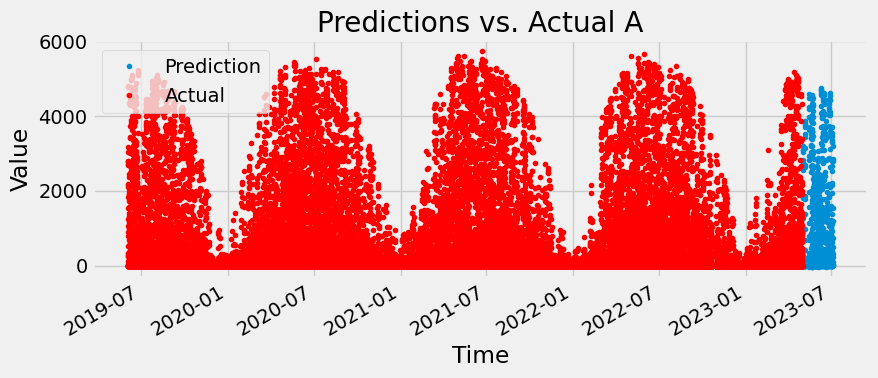

In [48]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

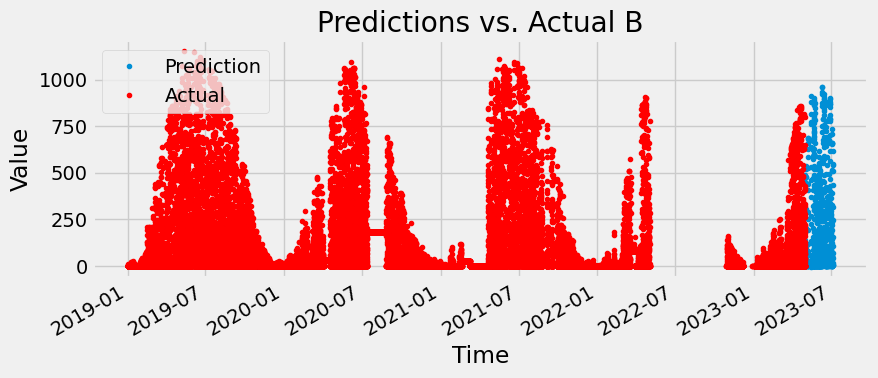

In [49]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


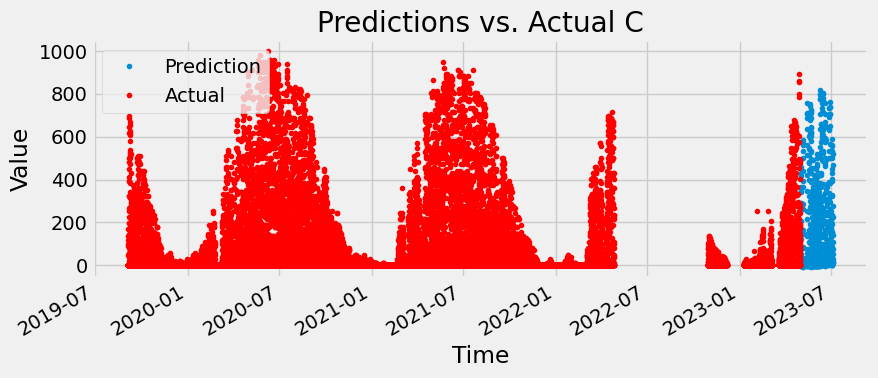

In [50]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

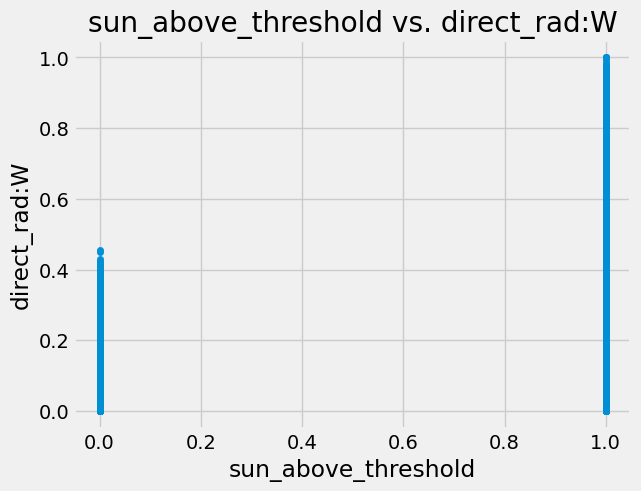

In [51]:
df.plot(x='sun_above_threshold', y='pv_measurement', kind='scatter')
plt.xlabel('sun_above_threshold')
plt.ylabel('direct_rad:W')
plt.title('sun_above_threshold vs. direct_rad:W')
plt.show()